Este Notebook contém minhas anotações, e é baseado no original disponível em: https://www.kaggle.com/code/phelpsmemo/cap-351-neurocomputacao-projeto4-autoencoder

# Projeto 4 - Experimentos com AutoEncoders

**Descrição do projeto**: Implementar AutoEncoder (Utilizando Keras ou não), variando o número de neurônios internos e o número de camadas (*stacks*). Deve-se visualizar a codificação gerada pelos neurônios da primeira camada oculta.

Deverão ser considerados os conjuntos de dados **MNIST** e **AR Face Database**.

**Biliotecas base**

Para o desenvolvimento deste projeto será feito o uso da biblioteca [Keras](https://keras.io/). Abaixo sua importação é feita junto a definição de um *seed* para a garantia de reprodutibilidade dos resultados que serão apresentados.


In [1]:
import os
import tensorflow
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.vis_utils import plot_model

import random as python_random

# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
random_seed = 777
python_random.seed(random_seed)
np.random.seed(random_seed)

tensorflow.random.set_seed(random_seed)

os.environ['PYTHONHASHSEED'] = str(random_seed)

**Funções auxiliares**

Abaixo são declaradas algumas funções auxiliares utilizadas para o desenvolvimento desta lista de exercícios.

> Algumas das funções declaradas abaixo foram adaptadas dos códigos feitos para o [Projeto 1 - Experimentos com a rede MultiLayer Perceptron (MLP)](https://www.kaggle.com/phelpsmemo/cap-351-neurocomputacao-projeto1-mlp).


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec


def plot_model_fit(fit_history: tensorflow.python.keras.callbacks.History, 
                   generate_figure = True,
                   custom_title    = "") -> None:
    """Função para visualizar a variação da acurácia de treino e teste do modelo ajustado
    
    Args:
        fit_history (tensorflow.python.keras.callbacks.History): Histórico do ajuste do modelo
    
        generate_figure (bool): Flag indicando se uma instância de matplotlib.pyplot.figure deve ser gerada
    See:
        https://www.kaggle.com/phelpsmemo/cap-351-neurocomputacao-projeto1-mlp
    Returns:
        None
    """
    
    if not custom_title:
        custom_title = 'Variação da função custo' 
    
    if generate_figure:
        plt.figure(dpi = 120)
        gs = gridspec.GridSpec(2, 1)
        sp0 = plt.subplot(gs[1])
        
        sp0.set_title(custom_title)
    else:
        sp0 = plt
        sp0.title(custom_title)

    sp0.plot(fit_history.epoch, fit_history.history['loss'])
    sp0.plot(fit_history.epoch, fit_history.history['val_loss'])
    
    sp0.grid(True)
    if generate_figure:
        sp0.legend(['Função custo', 'Função custo (Validação)'])
        plt.tight_layout()
        plt.show()

    
def visualize_reconstructed_data(n: int, 
                                 original_data: np.ndarray, 
                                 decoded_data: np.ndarray, 
                                 shape_data: tuple,
                                 legends = None) -> None:
    """Função para visualizar a reconstrução gerada com o uso de um modelo de AutoEncoder
    
    Args:
        n (int): Quantidade de imagens que serão apresentadas
        
        original_data (np.ndarray): Matrix n-dimensinal com os dados originais (Não reconstruidos)
        
        decoded_data (np.ndarray): Matrix n-dimensional com dados reconstruidos com o uso de um AutoEncoder
        
        shape (tuple): Shape 2D para converter os pesos em uma estrutura multidimensional que pode ser 
        apresentada como uma imagem
        
        legends (list): Legenda para cada subplot (Deve ser do mesmo tanho que a quantidade de subplots)
        
    See:
        https://blog.keras.io/building-autoencoders-in-keras.html
    Returns:
        None
    """
    
    for i in range(n):
        # Dados originais
        ax = plt.subplot(2, n, i + 1)

        plt.imshow(original_data[i].reshape(shape_data))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if legends:
            plt.title(legends[i])
        
        # Dados reconstruidos
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_data[i].reshape(shape_data))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if legends:
            plt.title(legends[i + n])

        
def visualize_layer_weights(n, layer, shape: tuple, grid_spec: tuple, neuron_name_pattern: str = "Neurônio {idx}"):
    """Função para visualizar os vetores de pesos associados a uma Layer
    
    Args:
        n (int): Quantidade de elementos que devem ser apresentados
        
        layer (tensorflow.python.keras.layers.core.Dense): Camada considerada
        
        shape (tuple): Shape 2D para converter os pesos em uma estrutura multidimensional que pode ser 
        apresentada como uma imagem
        
        grid_spec (tuple): Especificação do formato do grid utilizado para apresentar múltiplos pesos
    
    Returns:
        None
    """
    
    for i in range(0, n):
        ax = plt.subplot(*grid_spec, i + 1)
        # posição 0 do get_weights recupera os pesos ; posição 1 os bias
        plt.imshow(layer.get_weights()[0][:, i].reshape(shape))
        plt.gray()

        plt.title(neuron_name_pattern.format(idx = str(i + 1)), fontdict={"fontsize": 5})
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


### Experimento 1 - MNIST Dataset

Para a realização deste experimento será utilizado o conjunto de dados [MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/), disponibilizado por Yann Lecun. A criação do conjunto de dados foi feito dentro do contexto do projeto que deu origem as Redes Neurais Convolucionais. O conjunto disponibilizado é constituido de 70 mil imagens de números de 0 à 10 escritos manualmente. As imagens são formadas por 784 *pixels*, sendo dispostas em matrizes de `28x28`.

**Objetivo**: O principal objetivo deste experimento é realizar testes que ajudem no entendimento base de como os **AutoEncoders** `standard` funcionam.


**Importação dos dados**

A importação dos dados será feita com o auxílio da biblioteca [Keras](https://keras.io/), que disponibiliza funções auxiliares para a rápida aquisição de diferentes [datasets](https://keras.io/api/datasets/). Abaixo, o conjunto de dados MNIST é carregado. 

> Ao utilizar o Keras para realizar a importação, tem-se que os dados já estão em um padrão de `treino` e `teste`, sendo 60 mil imagens para treino e 10 mil imagens para teste.


In [3]:
from keras.datasets import mnist

mnist_data = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


**Exemplos de dados do *dataset***

Abaixo são apresentados alguns exemplos de imagens presentes no conjunto de dados MNIST.


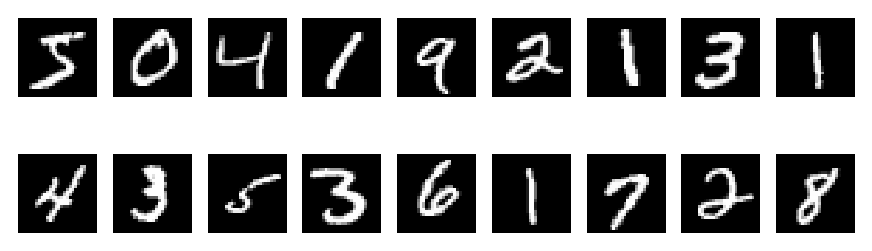

In [4]:
fig = plt.figure(dpi = 180)

for i in range(0, 18):
    ax = plt.subplot(4, 9, i + 1)
    plt.gray()
    ax.imshow(mnist_data[0][0][i], interpolation='nearest')
    ax.set_axis_off()

fig.subplots_adjust(hspace=0.01)

A importação dos dados feita acima, resulta em uma estrutura tridimensional. Nesta estrutura as dimensões de `x` e `y` tem são representadas como `28 x 28` e a dimensão `z` representa cada um dos dados utilizados para treino/teste. 

Esta estrutura é apresentada abaixo com o uso da *property* `shape`, presente nas classes de tipo `numpy.ndarray`.

In [5]:
type(mnist_data[0][0][0])

numpy.ndarray

In [6]:
mnist_data[0][0].shape  # treino

(60000, 28, 28)

In [7]:
mnist_data[0][0][0].shape  # imagem única

(28, 28)

Como citado, os dados ao serem carregados com a função `keras.datasets.mnist`, são entregues divididos em treino e teste. Para facilitar o uso, abaixo eles são separados em duas variáveis.

> Os rótulos de cada imagem (`y`) não serão carregados já que neste contexto, não estão sendo utilizados.


In [8]:
(x_train, _), (x_test, _) = mnist_data

Para finalizar a preparação dos dados, os valores presentes nas imagens serão normalizados entre `0` e `1` e as imagens serão transformadas em estruturas unidimensionais, de modo que a disposição bidimensional de `28 x 28` serão convertida em um vetor de `784` elementos.

In [9]:
# normalizando os dados
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.

# transformando todas as imagens armazenadas nos dados de treino e teste 
# em estruturas unidimensionais
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Teste 1 - Visualização das codificações

Neste primeiro teste será realizado a visualização das codificações criadas pelo `AutoEncoder` durante o processo de aprendizado. Para esta atividade, será inicialmente considerado o **AutoEncoder** `standard`, onde são empregados uma camada oculta para o **Encoder** (Camada de entrada + 1 Camada oculta) e uma camada de saída para o **Decoder**.

> Neste primeiro experimento, o modelo base utilizado é o descrito na publicação [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html), do blog oficial do Keras. Este modelo é composto por uma camada de entrada, uma camada escondida (Codificação) e uma camada de saída (Decodificação). 

> Como forma de explorar a [Keras API](https://keras.io/api/), a forma de construção dos modelos não será a mesma utilizada na publicação. Aqui, quando aplicável, os modelos serão organizados em *stacks* de camadas lineares através da classe [keras.Sequential](https://keras.io/api/models/sequential/).

Abaixo, o modelo é declarado para que os testes possam ser realizados.


In [10]:
input_dimension = 28 * 28

Na camada oculta de **Encoding** serão utilizados `32 neurônios` para a codificação.

In [11]:
code_dimension = 32

> No processo abaixo as camadas estão sendo nomeadas para tornar mais fácil a análise posterior. Assim, a camada de entrada é nomeada de `Test1_InputLayer`. A camada para codificação é nomeada de `Test1_Encoding` e por fim a camada de saída é `Test1_Decoding`.

In [12]:
test_1_autoencoder = keras.Sequential([
    keras.Input(shape = (input_dimension, ),                    name = "Test1_InputLayer"),
    keras.layers.Dense(code_dimension,  activation = 'relu',    name = "Test1_Encoding"),
    keras.layers.Dense(input_dimension, activation = 'sigmoid', name = "Test1_Decoding")
])

test_1_autoencoder.compile(
    optimizer = "adam",
    loss      = "binary_crossentropy"
)

A estrutura do modelo definido é apresentada abaixo com o auxílio da função `plot_model`, disponibilizada no módulo auxiliar `keras.utils.vis_utils` da bibliotecas Keras.

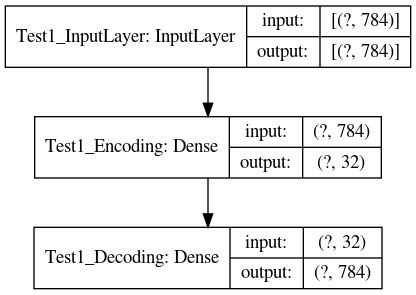

In [13]:
plot_model(model       = test_1_autoencoder, 
           show_shapes = True)

Agora será feito o treinamento do modelo.

> Note que, para seguir as definições dos **AutoEncoders**, a realização do treinamento da rede está sendo feita considerando que a entrada utilizada será o conjunto de dados de treinamento (`x_train`) e a saída esperada é o mesmo conjunto de dados (`x_train`), fazendo com que a rede aprenda o mapeamento do espaço $\mathbb{R}^n \Rightarrow \mathbb{R}^n$.

> Por uma questão de organização deste documento, o treinamento será feito com `verbose` desligado. Para que o *feedback* do processo de treinamento possa ser visualizado, é feita a criação de uma figura com as informações.

In [14]:
test_1_autoencoder_history = test_1_autoencoder.fit(
    x                = x_train, 
    y                = x_train,
    epochs           = 50,
    batch_size       = 256,
    shuffle          = True,
    validation_data  = (x_test, x_test),
    verbose          = False
)

Abaixo é feita a apresentação da variação da função de custo ao longo do processo de treinamento realizado.

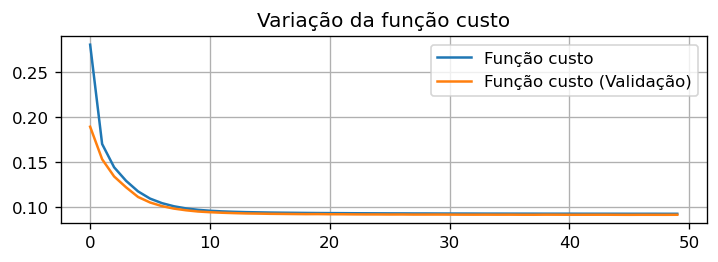

In [15]:
plot_model_fit(fit_history = test_1_autoencoder_history)

Agora, para verificar a precisão das reconstruções que estão sendo feitas pelo AutoEncoder treinado, abaixo são feitas reconstruções para todo o conjunto de dados e em seguida eles são visualizados junto aos dados originais.

> **Note que**, por conta da quantidade de dados, as visualizações geradas são feitas com dois grupos de imagens dos dados de teste (`x_test`). Em todas as figuras geradas a primeira linha representa os dados originais e a segunda os dados reconstruídos.

In [16]:
# Gerando a reconstrução dos dados
test1_reconstructed_xtest = test_1_autoencoder.predict(x_test)

**1° Visualização das reconstruções**

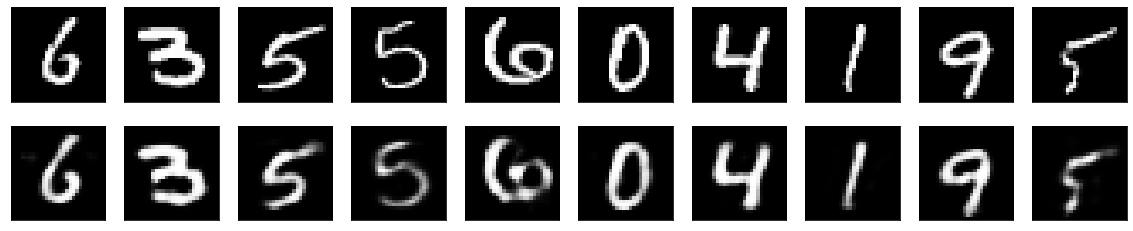

In [17]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[50:], test1_reconstructed_xtest[50:], (28, 28)
)

**2° Visualização das reconstruções**

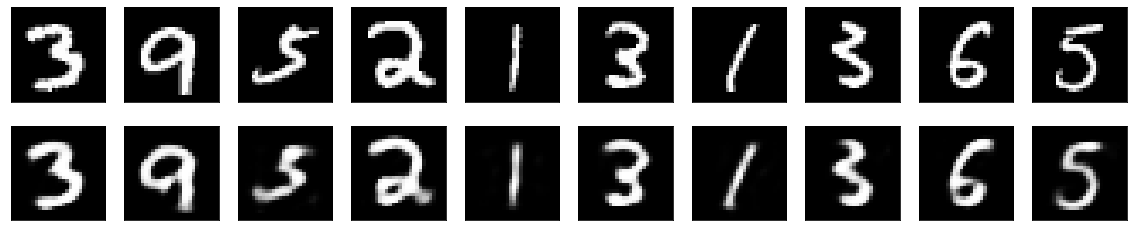

In [18]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[500:], test1_reconstructed_xtest[500:], (28, 28)
)

Como pode ser observado nas visualizações apresentadas acima, as reconstruções são feitas de maneira satisfatória, porém, para certos casos, apresentam certas divergências nos formatos. Tais divergências nos formatos podem ser explicadas pelo próprio processo de aprendizado, que como citado em aula, tende a gerar resultados próximos aos dados originais, mas com variações, por conta da sumarização das características do conjunto de dados em codificações de dimensões menores que a entrada.

Agora, como uma forma de entender as codificações internas que são criadas na rede, abaixo é feita a visualização dos pesos das camadas utilizadas nos processos de **Encoding** e **Decoding** realizado pela rede.

> Como o modelo base utilizado para o desenvolvimento desse teste é composto por apenas duas camadas, essas serão apresentadas abaixo.


**Visualização das codificações - Camada `Test1_Encoding`**

Nesta primeira visualização serão apresentados os pesos da camada `Test1_Encoding`. A figura abaixo destaca a qual camada os dados visualizados estão vinculados.

<div align="center">
   <img src="https://fmenino-cap351.netlify.app/homeworks/004_project_autoencoders/figures/png/03_test1_layers_visualization_a.png" width="230px">
</div>

<br>

A criação dessa visualização considera que, a camada que está sendo utilizada como base, possui 32 neurônios com 784 pesos associados, sendo cada um desses um *pixel* que é propagado da camada de entrada. Para deixar essa estrutura clara, abaixo os pesos da camada são recuperados e então sua estrutura dimensional é apresentada.

> Para a recuperação dos pesos das camadas ocultas está sendo feito o uso de dois componentes da classe `tensorflow.python.keras.engine.sequential.Sequential`, utilizada nesse teste para a representação dos AutoEncoders. Primeiro, faz-se o uso dos atributos `layers`, que devolve uma lista com as camadas presentes no modelo. Para cada camada presente na lista recuperada de `layers`, é utilizado o método `get_weights`, que recupera os pesos associados a cada camada e também os *bias*.


In [19]:
# Recupera as camadas presente no AutoEncoder
test_1_autoencoder.layers

In [20]:
test_1_autoencoder.layers[0].get_weights()

[array([[ 0.03310867, -0.05518857,  0.08548176, ...,  0.04689833,
         -0.06912096, -0.00016823],
        [-0.0670485 ,  0.02333996,  0.04733623, ...,  0.05367177,
          0.0210784 , -0.0834387 ],
        [-0.00557314, -0.03901741,  0.01988611, ...,  0.08418345,
         -0.0212458 , -0.03834758],
        ...,
        [ 0.06548225,  0.06868491,  0.00803409, ...,  0.04258693,
         -0.01545487,  0.0586326 ],
        [-0.03286384,  0.04169393, -0.03335074, ...,  0.04888809,
          0.03305412, -0.07873371],
        [-0.07713702, -0.05311886, -0.06052435, ..., -0.02807229,
         -0.05974064,  0.02915326]], dtype=float32),
 array([ 1.0694488 ,  1.0275279 , -0.30413923,  0.56417686, -0.52165824,
        -0.83526754,  0.0368058 ,  0.64078283,  2.6368632 ,  1.7169547 ,
         1.2309272 ,  0.12771079, -0.88181233,  0.6775966 ,  1.8203777 ,
         0.9873302 , -2.4272208 ,  0.22929445, -0.08559784,  0.66546685,
         1.2768974 ,  1.2857537 ,  0.7225607 ,  1.2287598 ,  2.209

In [21]:
# recupera os neurônios da primeira camada e apresenta
# a estrutura 784 x 32 citada anteriormente
test_1_autoencoder.layers[0].get_weights()[0].shape

(784, 32)

Com a descrição das características dos dados realizada, abaixo é feita a visualização da matriz de pesos associadas a cada um dos neurônios da primeira camada inserida no modelo.

> A visualização é feita abaixo com o auxílio da função `visualize_layer_weights`, que recebe uma camada, recupera seus pesos, converte para uma estrutura dimensional  que permite sua visualização como uma figura 2D e faz sua exibição.


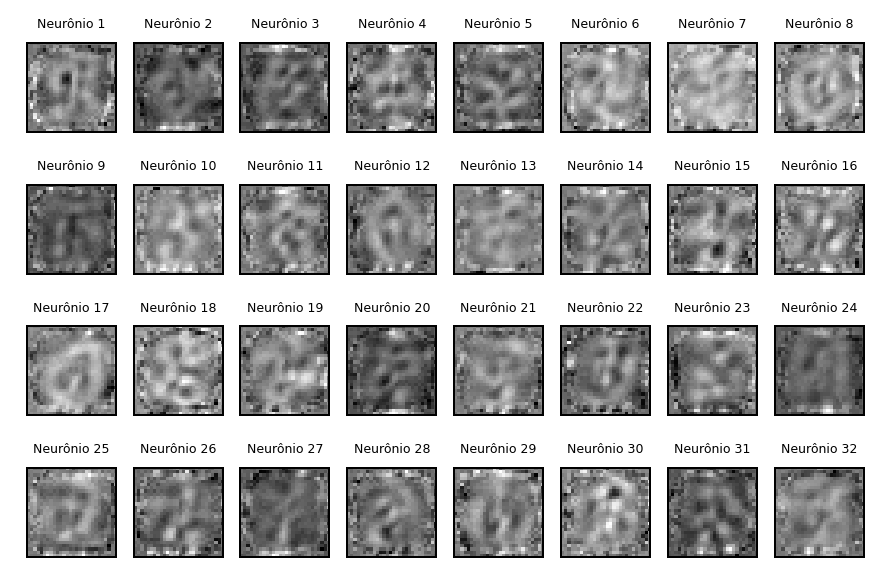

In [22]:
plt.figure(dpi = 180)

visualize_layer_weights(
    n         = 32,
    layer     = test_1_autoencoder.layers[0],
    shape     = (28, 28),  # estrutura dimensional utilizada
    grid_spec = (4, 8)
)

**Visualização das codificações - Camada `Test1_Decoding`**

Nesta etapa é feita a visualização dos pesos que estão associados à camada `Test1_Decoding`, que recebe as codificações feitas pelos neurônios da camada `Test1_Encoding` e realiza a decodificação gerando os resultados da rede.

<div align="center">
   <img src="https://fmenino-cap351.netlify.app/homeworks/004_project_autoencoders/figures/png/03_test1_layers_visualization_b.png" width="220px">
</div>

<br>

Como na camada `Test1_Decoding` estão presentes os 784 neurônios que serão utilizados para a reconstrução da saída, na visualização feita abaixo, apenas alguns dos neurônios serão apresentados.

> Cabe informar que o formato apresentado foi uma **escolha do processo de visualização**, **não refletindo** a maneira como os pesos são representados e consumidos pela rede neural. Em visualizações posteriores, outras formas de apresentação desses pesos também serão exploradas.


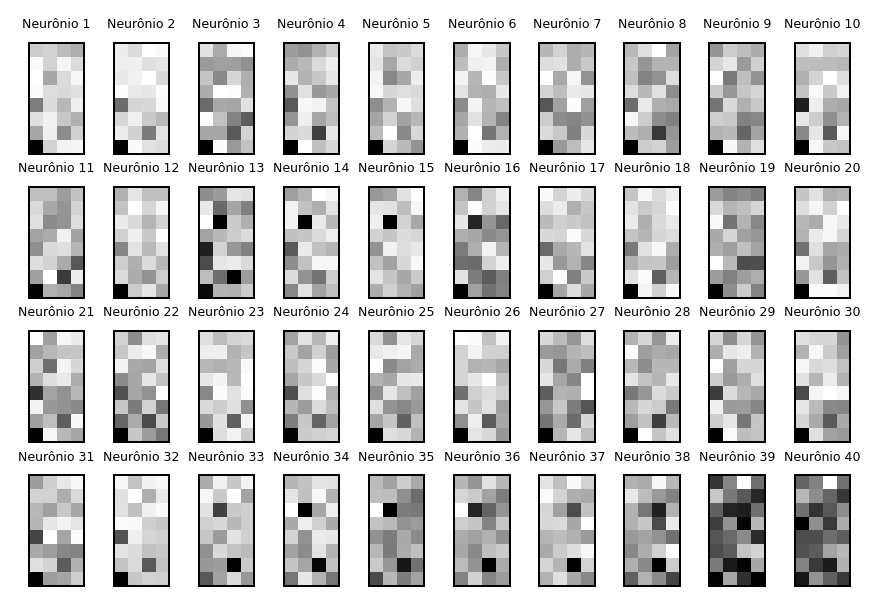

In [23]:
fig = plt.figure(dpi = 180)

visualize_layer_weights(
    n         = 40,
    layer     = test_1_autoencoder.layers[1],
    shape     = (8, 4),
    grid_spec = (4,10)
)

# ajustando os espaços entre os subplots
fig.subplots_adjust(hspace=0.3)

As figuras acima permitem a visualização das codificações que foram criadas, em cada uma das camadas da rede, durante o processo de treinamento. A codificação é criada com o objetivo de extrair características dos dados de modo a permitir que a saída gerada seja igual aos dados de entrada.

> Na visualização da primeira camada é possível notar certas formas e padrões presentes nos pesos

Para sumarizar o local onde cada um desses pesos são utilizadas no momento em que um novo dado é inserido na rede, fez-se a criação da figura apresentada abaixo. Na figura, é possível perceber que no momento em que os dados são passados pela camada de entrada, eles são multiplicados pelos pesos presentes na camada `Test1_Encoding`, após isso, eles são passados para a camada seguinte (`Test1_Decoding`), já em uma estrutura dimensional menor (`32-dimensional`) para que então a reconstrução dos dados possa ser realizada.


<div align="center">
   <img src="https://fmenino-cap351.netlify.app/homeworks/004_project_autoencoders/figures/png/04_test1_layers_visualization_general-workflow.png" width="700px">
</div>


### Teste 2 - Modificação na camada de codificação

Neste segundo teste será feita a modificação da quantidade de neurônios utilizados para a codificação, com o objetivo de entender o impacto nas reconstruções realizadas pela rede e nas representações internas que são criadas.

> Como forma de gerar comparações e entender as mudanças, esse teste utiliza como base o modelo definido no `Teste 1 - Visualização das codificações`.

Para o desenvolvimento desse teste duas simulações são realizadas. Na primeira, será feita a **redução** da quantidade de neurônios para a codificação e na segunda simulação, a codificação será feita com uma quantidade **maior** de neurônios.


**Simulação 1 - Utilizando menos neurônios para a codificação**

Para essa primeira simulação será feito o uso de `16 neurônios` (Metade do que foi utilizado no `Teste 1 - Visualização das codificações`). Todas as demais configurações e hiperparâmetros serão as mesmas já apresentadas no teste anterior.


In [24]:
input_dimension = 784 # 28 x 28 como apresentado anteriormente

code_dimension_test2_sim1 = 16

In [25]:
test_2_autoencoder_16_coding_units = keras.Sequential([
    keras.Input(shape = (input_dimension, ),                               name = "Test2_InputLayer"),
    keras.layers.Dense(code_dimension_test2_sim1,  activation = 'relu',    name = "Test2_Encoding"),
    keras.layers.Dense(input_dimension,            activation = 'sigmoid', name = "Test2_Decoding")
])

test_2_autoencoder_16_coding_units.compile(
    optimizer = "adam",
    loss      = "binary_crossentropy"
)

test_2_sim1_autoencoder_history = test_2_autoencoder_16_coding_units.fit(
    x                = x_train, 
    y                = x_train,
    epochs           = 50,
    batch_size       = 256,
    shuffle          = True,
    validation_data  = (x_test, x_test),
    verbose          = False
)

Abaixo é feita a apresentação da variação da `função de custo`. Ao analisar o resultado, mesmo diminuindo a capacidade de representação do modelo empregado para a geração do AutoEncoder, é observado que no processo de treinamento, tem-se variações parecidas as apresentadas no teste anterior, onde estavam presentes mais neurônios.

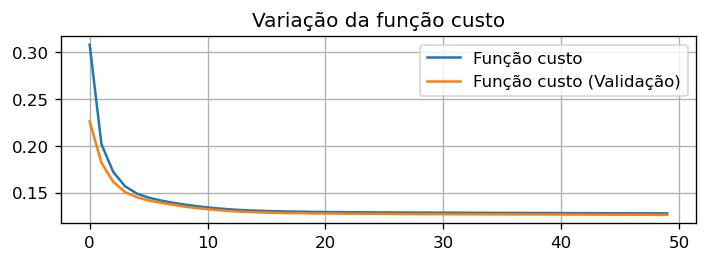

In [26]:
plot_model_fit(fit_history = test_2_sim1_autoencoder_history)

Antes de apresentar as codificações aprendidas, será feita a visualização da capacidade de reconstrução obtida pela rede após a alteração que foi realizada na camada de **Encoding**.

> Essa visualização será feita utilizando os dados de `Teste`. Os conjuntos de imagens visualizadas serão os mesmos apresentados no `Teste 1 - Visualização das codificações`, como forma de garantir que uma comparação possa ser realizada.


In [27]:
# Gerando as reconstruções nos dados de teste
test2_sim1_reconstructed_xtest = test_2_autoencoder_16_coding_units.predict(x_test)

**1° Visualização das reconstruções**

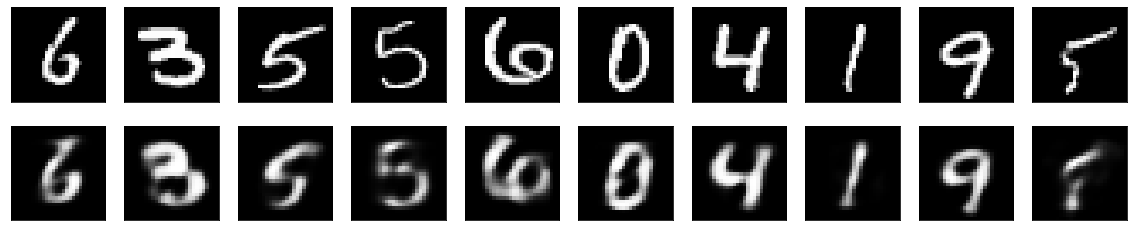

In [28]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[50:], test2_sim1_reconstructed_xtest[50:], (28, 28)
)

**2° Visualização das reconstruções**

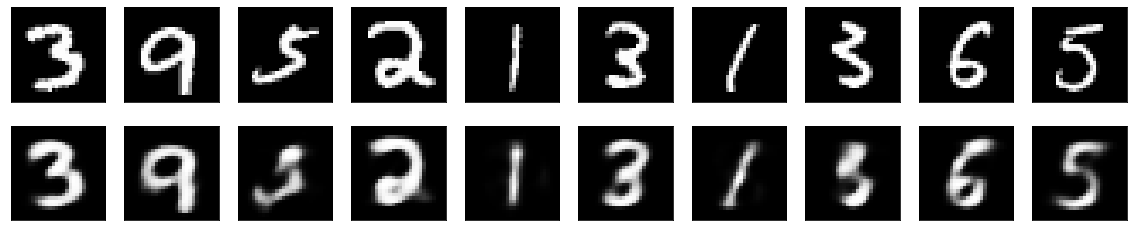

In [29]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[500:], test2_sim1_reconstructed_xtest[500:], (28, 28)
)

Como podem ser notados, os resultados apresentados com uma quantidade menor de neurônios envolvidos no processo de **Encoding** acabou resultando em uma quantidade maior de problemas para as reconstruções. Quando os resultados obtidos nessas simulações são comparados com o que foi apresentado no `Teste 1 - Visualização das codificações`, tais problemas são evidentes. Isso pode ser explicado pela quantidade menor de elementos envolvidos na extração das características para a criação das codificações.

Abaixo são apresentadas os pesos geradas na primeira e segunda camada do modelo treinado nesta simulação.


**1° Camada**

Pesos das camadas de entrada para a camada intermediária (**Encoder**). A representação feita abaixo inclui todos os neurônios da camada intermediária.


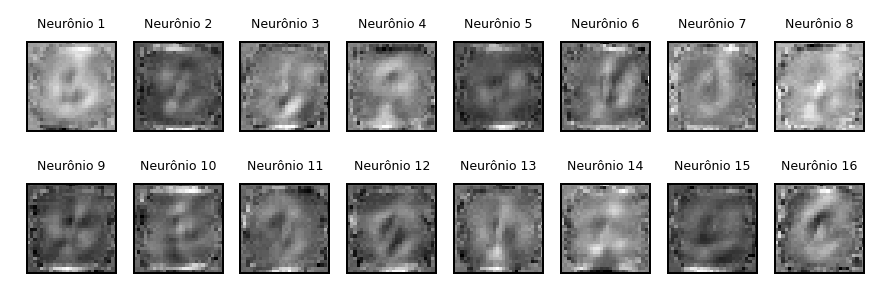

In [30]:
plt.figure(dpi = 180)

visualize_layer_weights(
    n         = 16,
    layer     = test_2_autoencoder_16_coding_units.layers[0],
    shape     = (28, 28),
    grid_spec = (4, 8)
)

**2° Camada**

Pesos da camada intermediária para a camada de saída (**Decoder**). Por conta da quantidade de elementos, nem todos os neurônios são apresentados na figura abaixo.


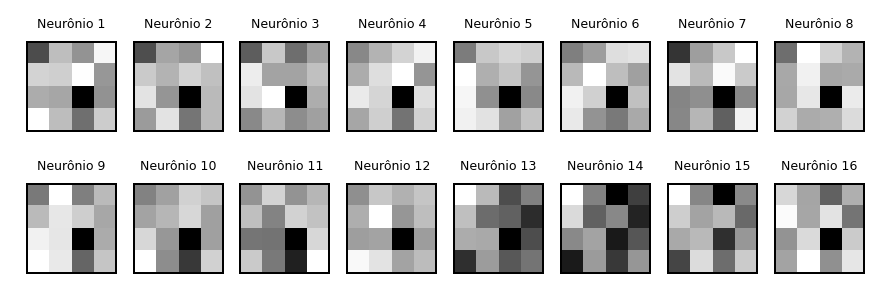

In [31]:
plt.figure(dpi = 180)

visualize_layer_weights(
    n         = 16,
    layer     = test_2_autoencoder_16_coding_units.layers[1],
    shape     = (4, 4),
    grid_spec = (4, 8)
)

**Simulação 2 - Utilizando mais neurônios para a codificação**

Nessa simulação será feito o uso de uma quantidade maior de neurônios para codificação do que a apresentada no modelo base do `Teste 1 - Visualização das codificações`. Assim, será feito o uso de `64 neurônios`, sendo o dobro do que foi utilizado no teste anterior.


In [32]:
input_dimension = 784

code_dimension_test2_sim2 = 64

In [33]:
test_2_autoencoder_64_coding_units = keras.Sequential([
    keras.Input(shape = (input_dimension, ),                               name = "Test2_InputLayer_Sim2"),
    keras.layers.Dense(code_dimension_test2_sim2,  activation = 'relu',    name = "Test2_Encoding_Sim2"),
    keras.layers.Dense(input_dimension,            activation = 'sigmoid', name = "Test2_Decoding_Sim2")
])

test_2_autoencoder_64_coding_units.compile(
    optimizer = "adam",
    loss      = "binary_crossentropy"
)

test_2_sim2_autoencoder_history = test_2_autoencoder_64_coding_units.fit(
    x                = x_train, 
    y                = x_train,
    epochs           = 50,
    batch_size       = 256,
    shuffle          = True,
    validation_data  = (x_test, x_test),
    verbose          = False
)

Abaixo, é feita a apresentação da variação da função de custo que foi obtido pelo modelo durante o processo de aprendizado. Como pode ser observado, mesmo havendo uma quantidade maior de neurônios para realizar as representações, o que se tem é um comportamento parecido com a simulação anterior, o que consequentemente o assemelha aos resultados apresentados no `Teste 1 - Visualização das codificações`.

> Nesse aumento de neurônios, além da semelhança citada é possível notar que a função de custo acabou tendo valores menores do que os vistos no `Teste 1`.


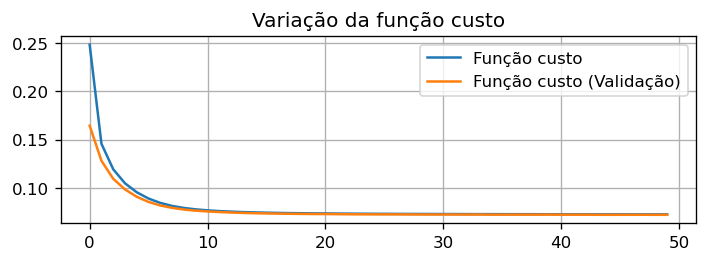

In [34]:
plot_model_fit(fit_history = test_2_sim2_autoencoder_history)

Agora, serão apresentadas as reconstruções feitas pelo modelo, para que essas possam ser avaliadas e comparadas com o resultado obtido na simulação anterior.

In [35]:
# Gerando a reconstrução dos dados (Com dados de teste)
test2_sim2_reconstructed_xtest = test_2_autoencoder_64_coding_units.predict(x_test)

**1° Visualização das reconstruções**

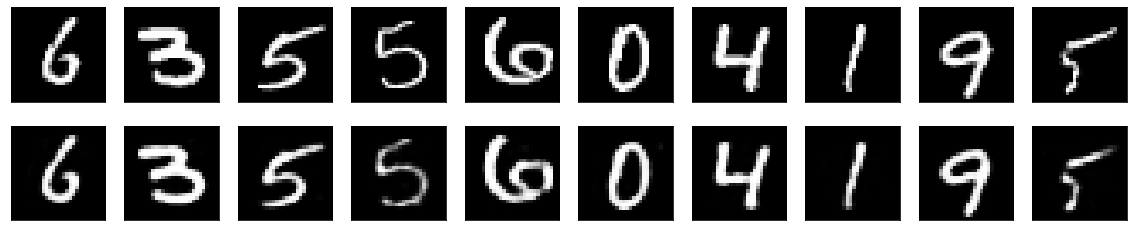

In [36]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[50:], test2_sim2_reconstructed_xtest[50:], (28, 28)
)

**2° Visualização das reconstruções**

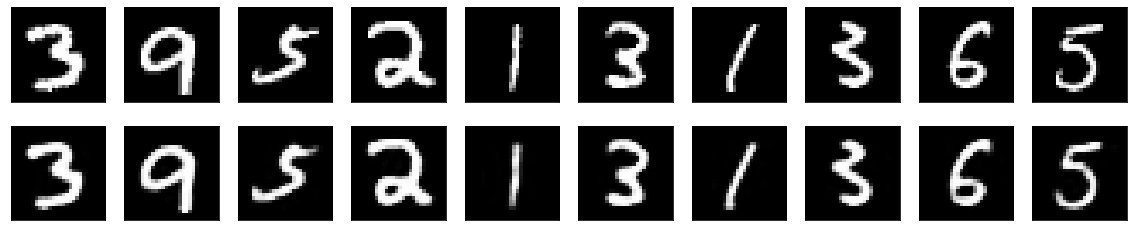

In [37]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[500:], test2_sim2_reconstructed_xtest[500:], (28, 28)
)

Ao analisar as reconstruções apresentadas acima é possível perceber que a adição de uma quantidade maior de neurônios para a realização do processo de **Encoding** acabou tornando possível a extração e constituição de uma quantidade maior de padrões, o que fez com que as perdas apresentadas na simulação anterior e mesmo as falhas vistas no `Teste 1` pudessem ser contornadas, gerando resultados bem mais próximos aos dados de entrada.

Para fechar este teste, abaixo é feita a apresentação dos padrões presentes nos neurônios de cada camada do modelo utilizado.


**1° Camada**

Pesos das camadas de entrada para a camada intermediária (**Encoder**). A representação feita abaixo inclui todos os neurônios da camada intermediária.


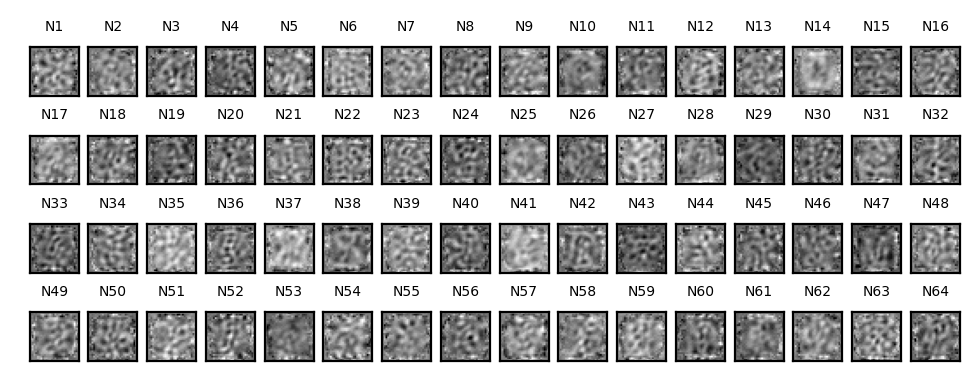

In [38]:
plt.figure(dpi = 200)

visualize_layer_weights(
    n         = 64,
    layer     = test_2_autoencoder_64_coding_units.layers[0],
    shape     = (28, 28),
    grid_spec = (7, 16),
    neuron_name_pattern = "N{idx}"
)

**2° Camada**

Pesos da camada intermediária para a camada de saída (**Decoder**). Por conta da quantidade de elementos, nem todos os neurônios são apresentados na figura abaixo.


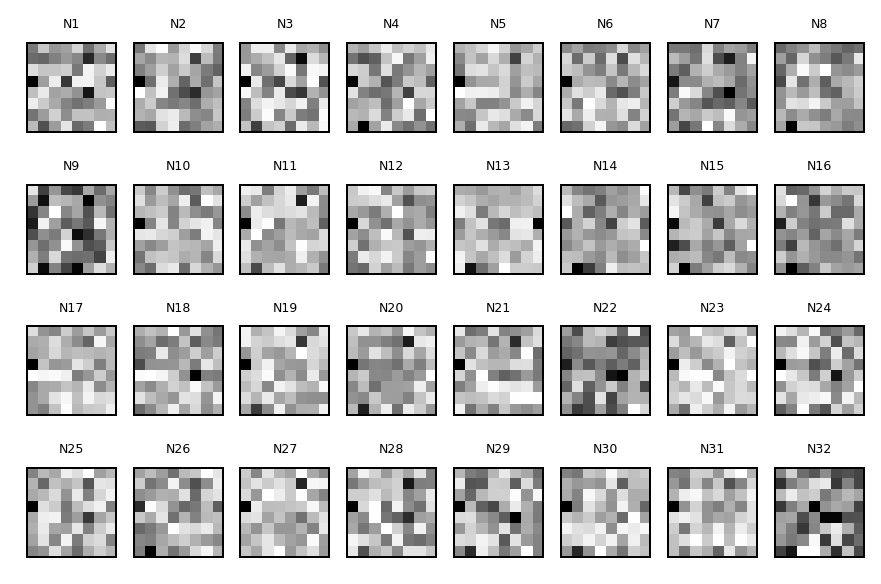

In [39]:
plt.figure(dpi = 180)

visualize_layer_weights(
    n         = 32,
    layer     = test_2_autoencoder_64_coding_units.layers[1],
    shape     = (8, 8),
    grid_spec = (4, 8),
    neuron_name_pattern = "N{idx}"
)

Com a visualização de cada uma das codificações aprendidas em ambas as simulações fica mais claro o entendimento da composição de características que são geradas durante o processo de treinamento para que um espaço N-dimensional possa ser inserido em um espaço dimensionalmente menor. Considerando tal característica, é possível perceber que o aumento de neurônios trouxe uma maior quantidade de padrões sendo representados.

### Teste 3 - Adição de mais camadas

Nos testes anteriores foram realizadas simulações com variações na quantidade de neurônios, mas, todos esses foram feitos com uma única camada oculta. Para entender o comportamento do AutoEncoder com a adição de mais camadas (**Deep AutoEncoder**), neste teste será feito a adição de mais camadas para o **Encoder** e **Decoder**. 

A realização desta atividade será feita considerado o uso do modelo base, apresentado no `Teste 1 - Visualização das codificações`, sendo feito neste a adição de mais camadas ocultas.

> O modelo foi implementado com o auxílio das notas apresentadas na publicação [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html).

Para a modificação do modelo base que será apresentada neste teste, alguns modelos foram definidos e treinados, sendo variado nesses os hiperparâmetros de quantidade de camadas e neurônios em cada uma delas. O objetivo foi criar uma estrutura de camadas que permitisse a extração granular de informações, começando com camadas com mais neurônios e então reduzindo nas camadas seguintes. Como forma de sumarizar este documento, apenas a versão que apresentou melhoras na reconstrução dos dados é utilizada.

Abaixo é feita a definição do modelo.


In [40]:
# a adição de mais camadas ocultas não muda a estrutura de entrada da rede
input_dimension = 28 * 28

In [41]:
# Modelo construído com a seguinte estrutura:
# (Entrada) 784 -> 256 -> 128 -> 64 -> 32 (Code) -> 64 -> 128 -> 256 -> 784 (Saída)

test_3_multiple_hidden_layers = keras.Sequential([
    keras.Input(shape = (input_dimension, ),  name = "Test3_InputLayer"),

    # Encoder
    ## camada 1
    keras.layers.Dense(256, activation = "relu",name = "Test3_Encoding_Layer1"),
    ## camada 2
    keras.layers.Dense(128, activation = "relu", name = "Test3_Encoding_Layer2"),
    ## camada 3
    keras.layers.Dense(64, activation = "relu", name = "Test3_Encoding_Layer3"),
    
    ## camada 4 (Code)
    keras.layers.Dense(32, activation = "relu", name = "Test3_Code_Layer4"),
    
    # Decoder
    ## camada 1
    keras.layers.Dense(64, activation = "relu",  name = "Test3_Decoding_Layer1"),
    ## camada 2
    keras.layers.Dense(128, activation = "relu", name = "Test3_Decoding_Layer2"),
    ## camada 3
    keras.layers.Dense(256, activation = "relu",name = "Test3_Decoding_Layer3"),
    ## camada 4 (Saída)
    keras.layers.Dense(input_dimension, activation = "sigmoid", name = "Test3_Decoding_Layer4_Out")
])

Com a definição do modelo realizada, abaixo é feita a apresentação de sua estrutura, de modo a deixar clara as ligações e transformações que serão aplicadas nos dados.

> Assim como citado, a estrutura apresentada foi definida através de alguns testes e execuções, os quais não foram mantidos para sumarização e organização deste documento e seu conteúdo.


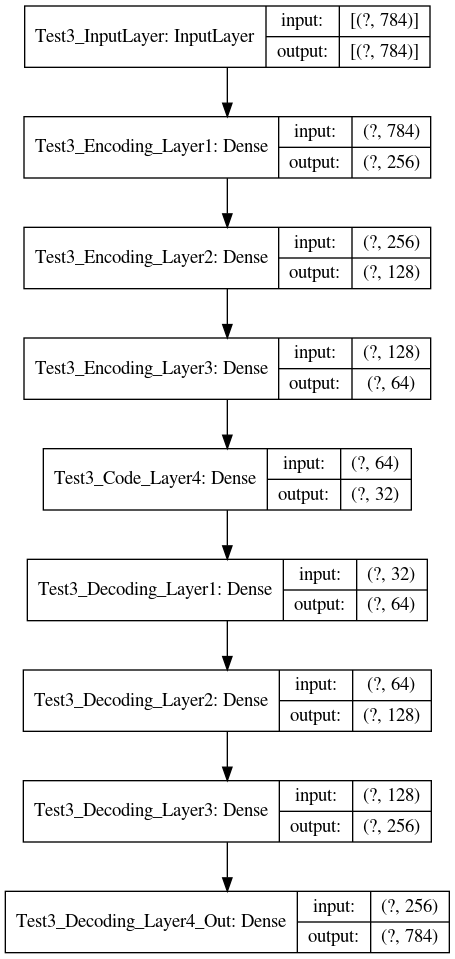

In [42]:
plot_model(model       = test_3_multiple_hidden_layers, 
           show_shapes = True)

Note que conforme descrito, a estrutura apresentada faz com que a redução de dimensionalidade seja feita em vários níveis, o que é útil por permitir que características e composições de comportamentos mais complexos possam ser extraídas pela rede durante o processo de aprendizado.

Agora o modelo será treinado usando os mesmos hiperparâmetros apresentada no `Teste 1 - Visualização das codificações`.


In [43]:
test_3_multiple_hidden_layers.compile(
    optimizer = "adam", 
    loss      = "binary_crossentropy"
)

test_3_autoencoder_history = test_3_multiple_hidden_layers.fit(
    x                = x_train,
    y                = x_train,
    epochs           = 50,
    batch_size       = 256,
    shuffle          = True,
    validation_data  = (x_test, x_test),
    verbose          = False
)

Abaixo é feita a visualização da variação da função de custo durante o processo de treinamento do modelo.

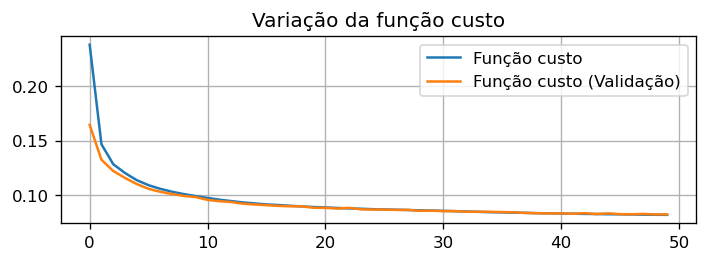

In [44]:
plot_model_fit(fit_history = test_3_autoencoder_history)

Agora, para verificar os impactos causados pela adição de mais camadas nos resultados do modelo, os dados presentes no conjunto de teste são reconstruídos e apresentados. Os mesmos conjuntos de imagens utilizados nos testes anteriores serão utilizados nas visualizações, para que possíveis comparações possam ser feitas.

In [45]:
# Gerando a reconstrução dos dados
test3_reconstructed_xtest = test_3_multiple_hidden_layers.predict(x_test)

**1° Visualização das reconstruções**

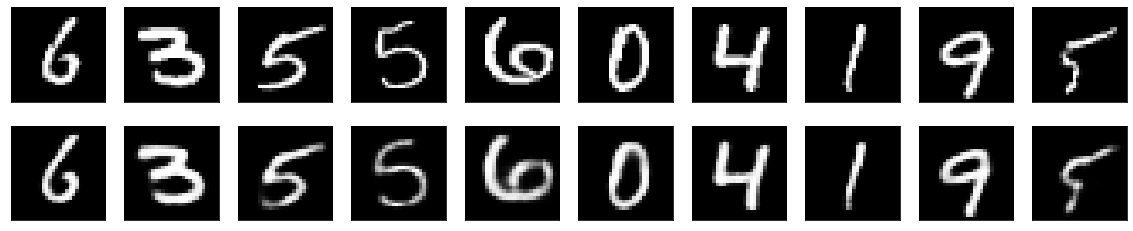

In [46]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[50:], test3_reconstructed_xtest[50:], (28, 28)
)

**2° Visualização das reconstruções**

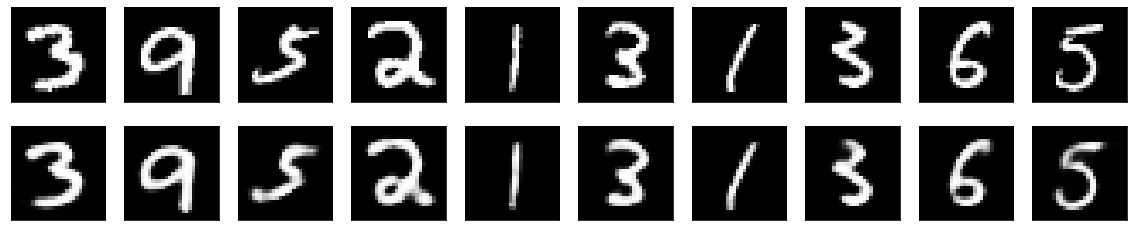

In [47]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[500:], test3_reconstructed_xtest[500:], (28, 28)
)

Na realização do segundo teste, especificamente na segunda simulação, o aumento na quantidade de neurônios acabou gerando melhores resultados que os até então obtidos com o modelo definido no `Teste 1 - Visualização das codificações`. Ao comparar os resultados obtidos acima com a `2° simulação do teste anterior`, tem-se que a adição de mais camadas, para os dados e hiperparâmetros que foram considerados, não apresentou uma grande melhora nos resultados. De maneira geral, o que foi visto na `2° simulação` pôde ser obtido no modelo com mais camadas, com a diferença de que, em certos pontos, pela quantidade de parâmetros à serem ajustados e a pouca quantidade de `epochs` empregadas, obteve-se resultados um pouco piores.

> Cabe notar que o processo de avaliação realizado é superficial e não trabalha com nenhum métrica de avaliação quantitativa. O uso de técnicas de comparação de imagens podem ser aplicados para esse contexto, porém, esses não foram considerados para o escopo desta lista de exercícios. Desta forma, apenas a avaliação geral foi considerada.


### Experimento 2 - AR Face Database

Neste segundo experimento serão realizados testes utilizando o conjunto de dados [AR Face Database](http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html). Este banco de dados facial foi criado por Aleix Martinez e Robert Benavente. O banco é composto por 4.000 imagens RGB correspondentes à 126 rostos de pessoas (70 homens e 56 mulheres). 

Todas as imagens que compõem o conjunto foram capturadas em uma visão frontal, com diferentes expressões faciais, condições de iluminação e também apresenta participantes que variam no uso de adereços (óculos de sol e lenço). Mais informações podem ser obtidas no [site](http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html) onde os dados estão sendo distribuídos livremente para uso acadêmico.

> **Referência dos dados**: A.M. Martinez and R. Benavente. The AR Face Database. CVC Technical Report #24, June 1998.

Para o uso desse conjunto de dados nesta lista de exercícios foi criado um conjunto de *scripts* que permite a aquisição e organização dos dados. A figura abaixo apresenta o fluxo de funcionamento dos *scripts* que foram desenvolvidos.

<br>

<div align="center">
   <img src="https://fmenino-cap351.netlify.app/homeworks/004_project_autoencoders/figures/png/05_ar-face-workflow.png" width="700px">
</div>

<br>

Conforme apresentando, inicialmente faz-se a aquisição dos dados disponibilizados no site oficial, em seguida, é aplicado um processamento que converte as imagens RGB (768x576x3) para figuras em tons de cinza reduzidas (128x128). Ao final do processo, os dados são salvos em um arquivo `.npz` comprimido. Este processo foi realizado considerando os 8 CDs de imagens estatísticas que estão disponíveis no site de distribuição, o que gera um conjunto de dados com `3315 imagens`. As demais imagens pertencem a um conjunto de `sequências` (30 sequências de 25 imagens cada), que não foram consideradas para este trabalho.

> A redução dos canais de cores e também do tamanho de cada figura foram feitas para diminuir os recursos computacionais necessários para a utilização do conjunto de dados com os AutoEncoders.

> Os *scripts* que materializam o fluxo apresentado na figura estão disponíveis no [Github](https://github.com/M3nin0/ar-face-database).

> Para tornar o uso dos dados processados por este conjunto de *script* mais fácil, eles foram disponibilizados no Kaggle: [AR Face Database (128x128)](https://www.kaggle.com/phelpsmemo/ar-face-database-128x128). Caso seja necessário validar ou mesmo utilizar os dados fora do Kaggle, eles também estão disponíveis para *download* [no site criado para a distribuição dos conteúdos da disciplina](https://fmenino-cap351.netlify.app/homeworks/004_project_autoencoders/data/ar_database_stacked_128x128.npz).


**Importação dos dados**

Como esta lista de exercícios está sendo desenvolvida com o auxílio do Kaggle, o conjunto de dados será importado utilizando das funcionalidades do ambiente. Desta forma, um *link* entre este notebook e o [conjunto de dados](https://www.kaggle.com/phelpsmemo/ar-face-database-128x128) foi realizado, assim, os dados passam a ficar disponível no mesmo local de trabalho onde estão os *notebooks*.

Abaixo, os dados são carregados do diretório onde eles estão armazenados no Kaggle.


In [48]:
ar_database = np.load("../input/ar-face-database-128x128/ar_database_stacked_128x128.npz")["stack"]

**Exemplos de dados do *dataset***

A figura abaixo apresenta exemplos de imagens que estão presentes no *AR Face dataset*.


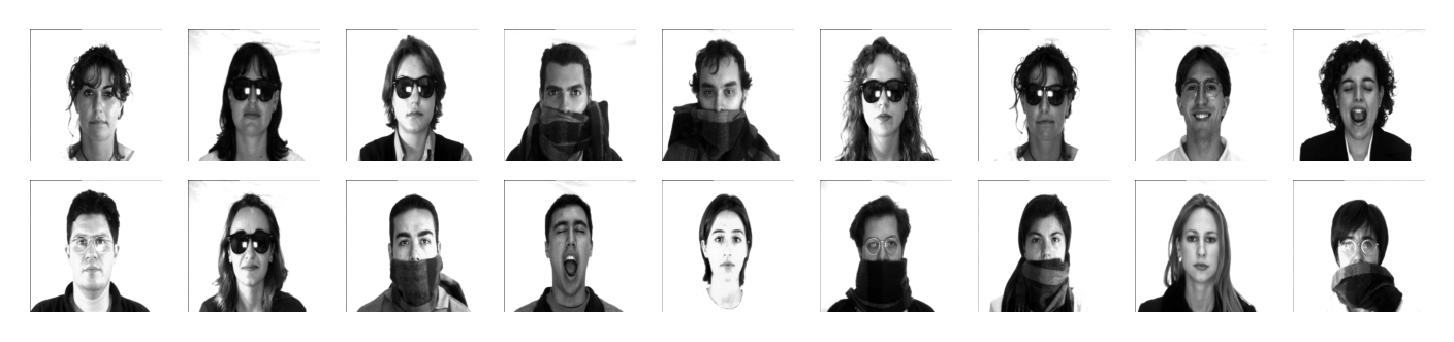

In [49]:
fig = plt.figure(dpi = 300)

for i in range(0, 18):
    ax = plt.subplot(6, 9, i + 1)
    plt.gray()
    ax.imshow(ar_database[i, :, :], interpolation='nearest')
    ax.set_axis_off()

fig.subplots_adjust(hspace=0.01)

Para começar os testes deste experimento, abaixo é feita a divisão dos dados nos conjuntos de `Treino` (80%) e `Teste` (20%). Junto a este processo é feita a normalização e também a remoção do fundo de cada um dos dados.

> A remoção do fundo está sendo aplicada já que ao longo dos testes que foram feitos com esse conjunto de dados antes da realização dessa lista, foram encontradas dificuldades para a criação de AutoEncoders com resultados satisfatórios nas reconstruções quando o fundo estava presente. Para o escopo desta lista foi considerado  na remoção do fundo das imagens um simples filtro dos *pixels* por limiar. Este filtro, trouxe para alguns casos, pequenos ruídos.


In [50]:
# todo valor maior que 99 é passado para 0
# 99 está representando os valores mais claros (0 à 100)
ar_database[ar_database >= 99] = 0

In [51]:
x_train = ar_database[0:2652, :, :] / 100.
x_test = ar_database[2652:, :, :] / 100.

print(f"Treino (80%): {x_train.shape[0]}")
print(f"Teste  (20%): {x_test.shape[0]}")
print(f"Total       : {x_test.shape[0] + x_train.shape[0]}")

Treino (80%): 2652
Teste  (20%): 663
Total       : 3315


Após as transformações os dados são apresentados da seguinte forma:

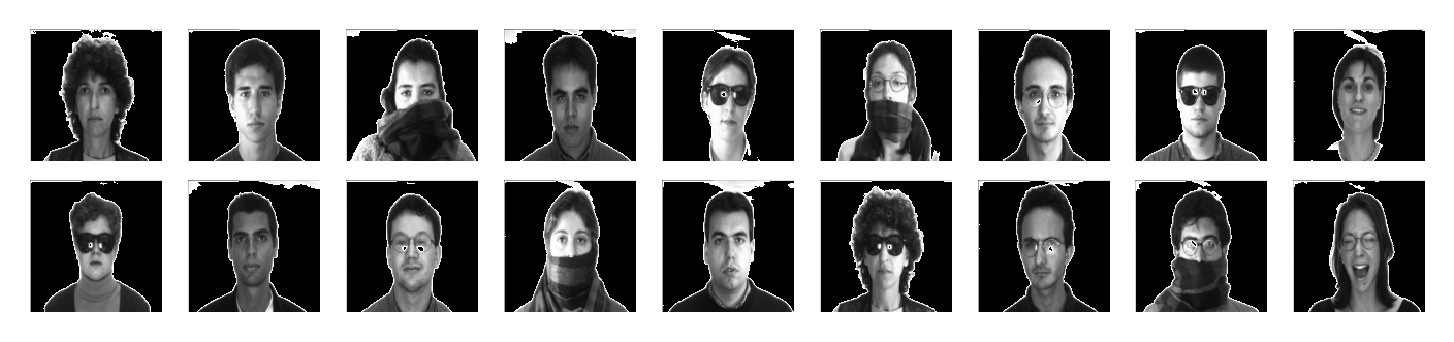

In [52]:
fig = plt.figure(dpi = 300)

for i in range(0, 18):
    ax = plt.subplot(6, 9, i + 1)
    plt.gray()
    ax.imshow(x_test[270 + i, :, :], interpolation='nearest')
    ax.set_axis_off()

fig.subplots_adjust(hspace=0.01)


Por fim, é feita a transformação desses dados para que eles possam ser representados em *arrays* unidimensionais.

In [53]:
x_train = x_train.reshape((len(x_train), np.prod(
    x_train.shape[1:]
)))

x_test = x_test.reshape((len(x_test), np.prod(
    x_test.shape[1:]
)))

### Teste 1 - Quantidade de neurônios

Neste primeiro teste serão consideradas simulações com modelos de AutoEncoders variando a quantidade de neurônios utilizadas em uma única camada. O objetivo é explorar as combinações que podem ser utilizadas para gerar reconstruções de dados com a melhor qualidade possível com apenas uma única camada.

Como ponto de partida será feito o uso do mesmo modelo empregado no `Experimento 1: Teste 1 - Visualização das codificações`. Em seguida, variações na quantidade de neurônios para a codificação são feitas com o objetivo de explorar os comportamentos que podem ser gerados.


**Funções auxiliares**

Abaixo são definidas funções que auxiliam o desenvolvimento deste teste.


In [54]:
def exp2_test1_generate_base_model_with_different_encoding_nneurons(n_units: int, 
                                                                    x_train: np.ndarray, 
                                                                    x_test: np.ndarray,
                                                                    epochs: int = 50, 
                                                                    batch_size: int = 256,
                                                                    base_models = None):
    """Função para gerar e treinar modelos base (Experimento 2: Teste 1)
    
    Args:
        n_units (int): Quantidade de neurônios na camada oculta de encoding
        
        x_train (np.ndarray): Conjunto de dados utilizado para treino dos modelos
        
        x_test (np.ndarray): Conjunto de dados utilizado para teste dos modelos
        
        epochs (int): Quantidade de épocas de treinamento
        
        batch_size (int): Tamanho do batch utilizado no treinamento
        
        base_models (list): Estruturas de modelos já definidas. Caso não definida, uma estrutura
        com apenas uma camada de codificação será gerada.
    Returns:
        dict: Dicionário com o modelo treinado (model), historico de treinamento (history) e
        quantidade de neurônios utilizados (units)
    """
    
    res_dict = {
        "model": [],
        "history": [],
        "units": n_units
    }
    
    if not base_models:
        base_models = [
            keras.Sequential([
                keras.Input(shape = (x_train.shape[1])),
                keras.layers.Dense(unit,  activation = 'relu'),
                keras.layers.Dense(x_train.shape[1], activation = 'sigmoid')
            ]) for unit in n_units
        ]
    
    for base_model in base_models:
        base_model.compile(
            optimizer = "adam",
            loss      = "binary_crossentropy"
        )
        
        history = base_model.fit(
            x                = x_train, 
            y                = x_train,
            epochs           = epochs,
            batch_size       = batch_size,
            shuffle          = True,
            validation_data  = (x_test, x_test),
            verbose          = False
        )
        
        res_dict["history"].append(history)
    res_dict["model"] = base_models
    
    return res_dict


def predict_using_multiple_models(models_dict, x_test):
    """Função para fazer a predição de dados utilizando múltiplos modelos
    
    Args:
        models_dict (dict): Dicionário contendo as chaves {history, units, model}.
        Essa estrutura de dicionário é gerada pela função exp2_test1_generate_base_model_with_different_encoding_nneurons
        
        x_test (np.ndarray): Conjunto de dados de teste a ser utilizado para as predições
    Returns:
        dict: Dicionário de entrada com a chave "predicts" contendo as predições de cada modelo
        para o conjunto de teste (x_test) inserido.
    """
    
    # Gerando as reconstruções para cada modelo.
    models_dict["predicts"] = []

    for i in range(0, len(models_dict["units"])):
        models_dict["predicts"].append(
            models_dict["model"][i].predict(x_test)
        )
    return models_dict


def prepare_data_to_plot_with_one_predict_for_multiple_models(models_dict, predict_index, x_test):
    """Função para preparar os dados para a visualização da predição de uma mesma
    amostra para múltiplos modelos
    
    Args:
        models_dict (dict): Dicionário contendo as chaves {history, units, model, predicts}.
        Essa estrutura de dicionário é gerada pela função exp2_test1_generate_base_model_with_different_encoding_nneurons.
        A chave {predicts} é gerada com a função predict_using_multiple_models.
        
        predict_index (int): índice da amostra que será utilizada para a visualização de seu resultado em múltiplos modelos
        
        x_test (np.ndarray): Conjunto de dados de teste de onde a amostra será retirada
    Returns:
        tuple: Tupla com os dados originais e reconstruidos para cada modelo
    """
    
    units = models_dict["units"]
    reconstructed_data_per_model = []
    
    for i in range(0, len(units)):    
        reconstructed_data_per_model.append(models_dict["predicts"][i][predict_index])
        
    return (np.stack([x_test[predict_index] for i in units]), np.stack(reconstructed_data_per_model))


def plot_multiple_loss_variation(models_dict: dict, grid_spec = (2, 2)):
    """Função para visualizar a função de perda gerada por diversos modelos durante o processo de treinamento
    
    Args:
        models_dict (dict): models_dict (dict): Dicionário contendo as chaves {history, units, model, predicts}.
        Essa estrutura de dicionário é gerada pela função exp2_test1_generate_base_model_with_different_encoding_nneurons.
        
        grid_spec (tuple): Especificação do formato do grid utilizado.
    Returns:
        None
    """
    
    fig = plt.figure(dpi = 180)
    
    for i in range(0, len(models_dict["units"])):
        ax = plt.subplot(*grid_spec, i + 1)

        plot_model_fit(
            fit_history     = models_dict["history"][i], 
            generate_figure = False,
            custom_title    = f"Neurônios = {models_dict['units'][i]}"
        )
        
    plt.legend(['Função custo', 'Função custo (Validação)'], prop={'size': 8})
    fig.subplots_adjust(hspace=0.5)


**Modelo base**

Para este primeiro teste será feito o uso do mesmo modelo empregado no `Experimento 1: Teste 1 - Visualização das codificações`. O objetivo é verificar os resultados que podem ser gerados com um modelo simples frente a um conjunto de dados complexo, onde há diversos detalhes em cada uma das imagens. Abaixo o modelo é definido e treinado.

> Em comparação ao modelo de referência, houve uma mudança inicial apenas na camada de entrada, a qual será adaptada para receber não mais `28 x 28`, mas sim `128 x 128` (Dimensão dos dados que estão sendo utilizados)


In [55]:
code_dimension = 32  # (Code)
input_dimension = 128 * 128

In [56]:
exp2_test_1_autoencoder = keras.Sequential([
    keras.Input(shape = (input_dimension, ),                    name = "Exp2Test1_InputLayer"),
    keras.layers.Dense(code_dimension,  activation = 'relu',    name = "Exp2Test1_Encoding"),
    keras.layers.Dense(input_dimension, activation = 'sigmoid', name = "Exp2Test1_Decoding")
])

exp2_test_1_autoencoder.compile(
    optimizer = "adam",
    loss      = "binary_crossentropy"
)

Agora o modelo será treinado.

In [57]:
exp2_test_1_autoencoder_history = exp2_test_1_autoencoder.fit(
    x                = x_train, 
    y                = x_train,
    epochs           = 50,
    batch_size       = 256,
    shuffle          = True,
    validation_data  = (x_test, x_test),
    verbose          = False
)

Abaixo é feita a apresentação da variação na função de custo. De maneira geral, mesmo trabalhando com uma pequena quantidade de neurônios para a codificação, os erros foram reduzindo consideravelmente ao longo do processo. É possível perceber uma variação com uma quantidade de erro maior do que as vistas nos testes e simulações anteriores.

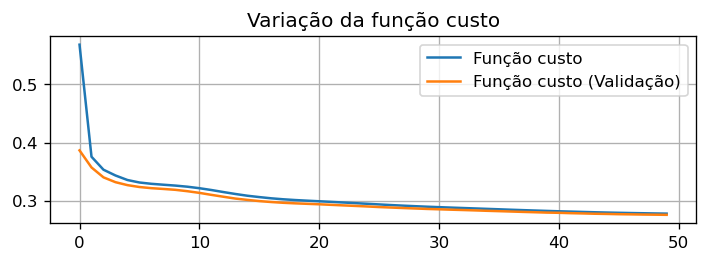

In [58]:
plot_model_fit(fit_history = exp2_test_1_autoencoder_history)

Agora, para avaliar os resultados que foram gerados, é feita a visualização das reconstruções que podem ser geradas com o uso do modelo treinado.

> Seguindo as definições realizadas no `Experimento 1 - MNIST Dataset`, serão apresentadas dois conjuntos de imagens, retirados do conjunto de teste (`x_test`).

> Da mesma forma como realizado nos demais testes, na visualização dos resultados a linha superior representa os dados originais e a linha inferior os dados reconstruídos.


In [59]:
exp2_test1_reconstructed_xtest = exp2_test_1_autoencoder.predict(x_test)

**1° Visualização das reconstruções**

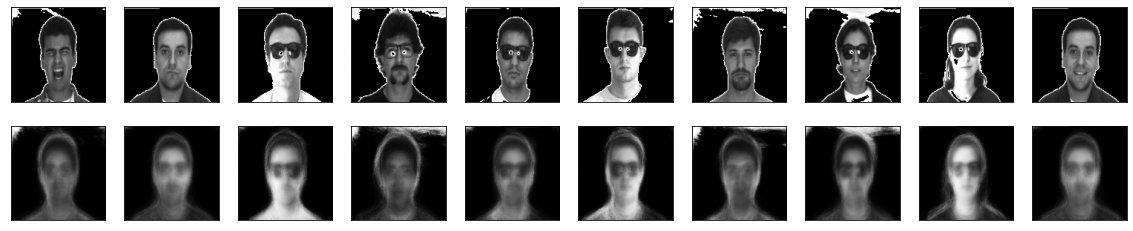

In [60]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[50:], exp2_test1_reconstructed_xtest[50:], (128, 128)
)

**2° Visualização das reconstruções**

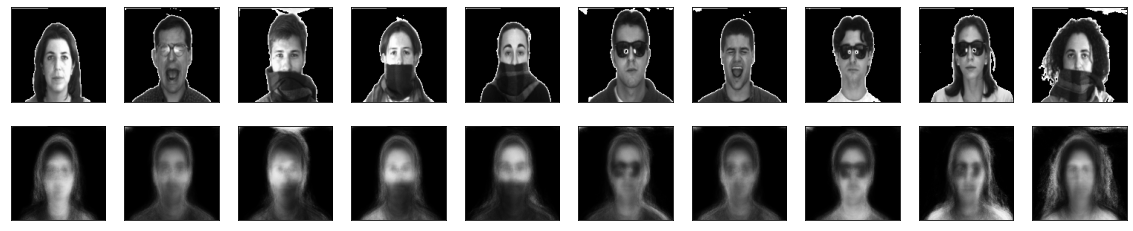

In [61]:
plt.figure(figsize=(20, 4))

visualize_reconstructed_data(
    10, x_test[500:], exp2_test1_reconstructed_xtest[500:], (128, 128)
)

Com a avaliação dos resultados é possível perceber que a codificação do conjunto de dados com a quantidade de neurônios definida reduziu a capacidade de extração e combinação de características dos dados, gerando reconstruções gerais, não tratando das características específicas de cada dado.


**Modelos com mais neurônios**

Buscando resolver o problema apresentado com o uso do modelo base, onde visualmente as reconstruções apresentaram perdas de características, será feita a criação de um segundo modelo com uma quantidade maior de neurônios para o processo de codificação.

Como este é um processo empírico, serão treinados alguns modelos que variam a quantidade de neurônios em **uma camada oculta**. Assim, serão testadas as quantidades de `64`, `128`, `256` e `512` neurônios em uma única camada.

> O treinamento de vários modelos é feito com a função `exp2_test1_generate_base_model_with_different_encoding_nneurons`, que automaticamente define o modelo com uma quantidade diferentes de neurônios na camada escondida de codificação e realiza seu treinamento.

In [62]:
units = [64, 128, 256, 512]

exp2_test1_multiple_models = exp2_test1_generate_base_model_with_different_encoding_nneurons(
    n_units    = units,
    x_train    = x_train, 
    x_test     = x_test,
    epochs     = 50,
    batch_size = 256
)

Abaixo é feita a visualização da função de perda de cada um dos modelos gerados.

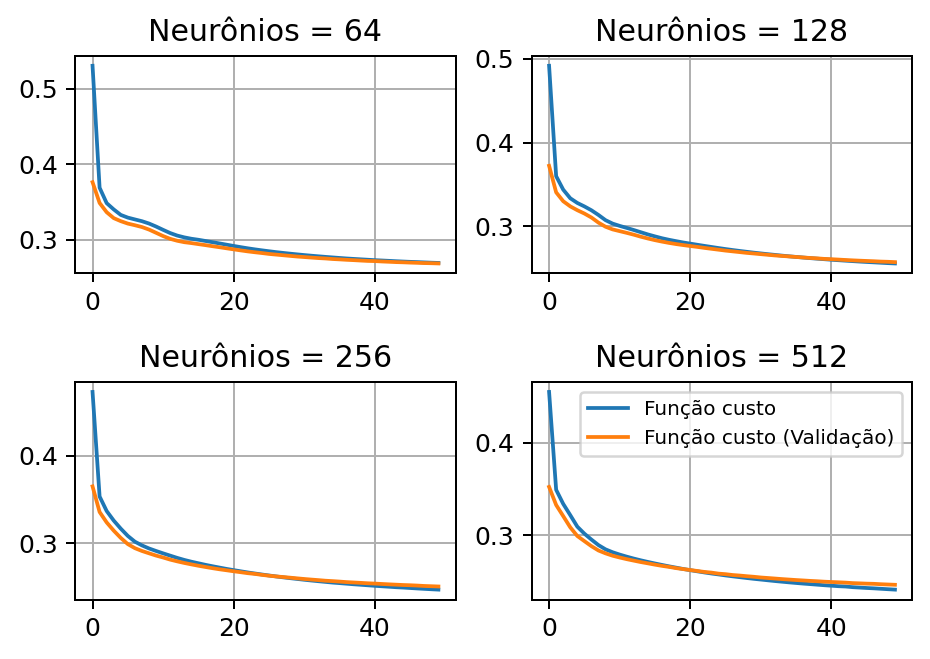

In [63]:
plot_multiple_loss_variation(exp2_test1_multiple_models)

Como apresentado pela figura acima, mesmo aumentando a capacidade de representação dos modelos, durante o processo de treinamento a variação da função de perda entre os modelos não teve resultados muito diferentes.  Para entender o comportamento de cada modelo, abaixo são apresentadas reconstruções de figuras do conjunto de dados feitas por cada um deles.

**1° Visualização das reconstruções**

Serão exibidos abaixo os dados originais (Linha superior) e suas reconstruções por cada um dos modelos (Linha inferior). Para isso, é feita a organização dos dados de modo que a função auxiliar `visualize_reconstructed_data` possa ser utilizada.

> A reconstrução de uma mesma figura utilizando diferentes modelos é feita com o auxílio da função `predict_using_multiple_models`. As prediçõs geradas são consumidas pela função `prepare_data_to_plot_with_one_predict_for_multiple_models`, que organiza os dados para que eles possam ser consumidos pela função `visualize_reconstructed_data`.

In [64]:
exp2_test1_multiple_models = predict_using_multiple_models(exp2_test1_multiple_models, x_test)

original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test1_multiple_models,
    predict_index = 50,  # índice da imagem utilizada
    x_test        = x_test
)

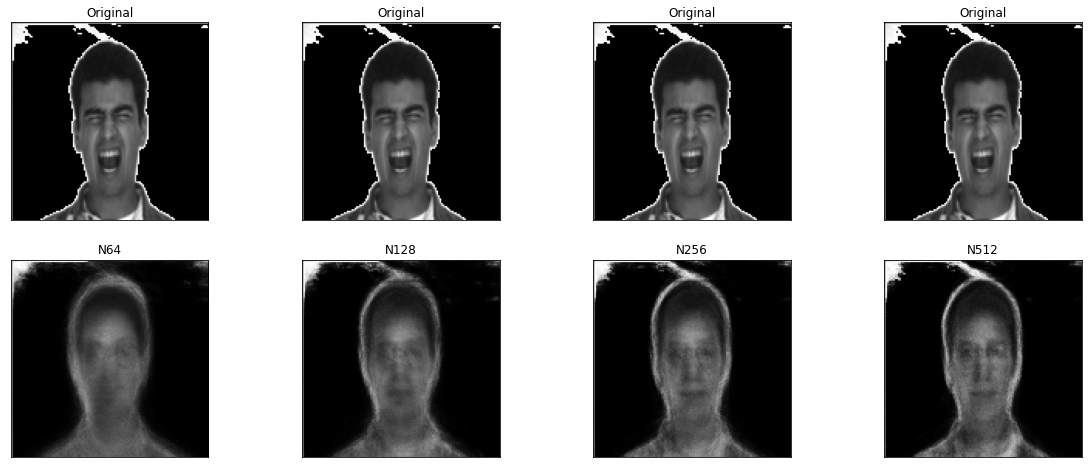

In [65]:
plt.figure(figsize=(20, 8))

# definindo legendas
legends = ["Original", "Original", "Original", "Original",
          "N64", "N128", "N256", "N512"]

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

**2° Visualização das reconstruções**

In [66]:
original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test1_multiple_models,
    predict_index = 177,
    x_test        = x_test
)

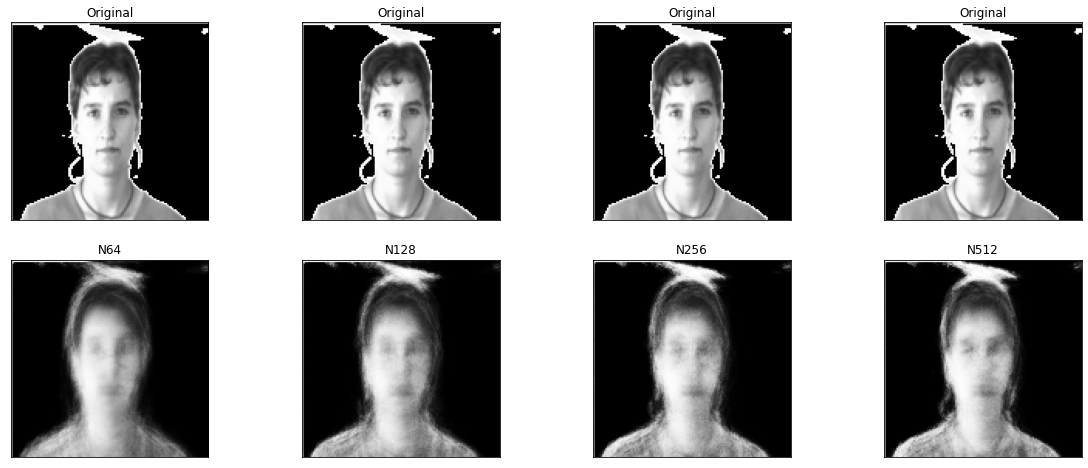

In [67]:
plt.figure(figsize=(20, 8))

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

Com base em ambas as visualizações apresentadas é possível perceber que mesmo com o uso de uma única camada, o aumento da quantidade de neurônios fez com que mais características pudessem ser extraídas, seguindo os mesmos resultados apresentados no `Experimento 1: Teste 2 - Modificação na camada de codificação`.

Embora haja melhorias nos resultados, a reconstrução ainda é muito geral, apresentando poucas especificidades nos rostos, o que pode ser explicado pela complexidade de características que estão presentes nos dados. Para permitir que características de mais alto nível sejam extraídas, será feito a seguir um teste em que mais camadas são consideradas no modelo.

### Teste 2 - Quantidade de camadas

Como citado anteriormente, o trabalho com uma única camada apresentou dificuldade para a extração de características mais específicas do conjunto de dados. Com o objetivo de obter melhores resultados na reconstrução, este teste será realizado considerando a adição de mais camadas no AutoEncoder (**Deep AutoEncoder**).

Para a realização deste teste será utilizado como base o modelo com uma camada oculta de `512 neurônios`, definido no teste anterior.

**Simulação 1 - Duas camadas para Encoding-Decoding**

Nesta primeira simulação, diferente do que foi feito no teste `Experimento 2: Teste 1 - Quantidade de neurônios`, será considerada a adição de mais camadas para o **Encoder** e **Decoder** de modo a permitir que a codificação/decodificação seja feita em uma estrutura de múltiplos níveis. Como visto no `Experimento 1 - MNIST Dataset`, tal estrutura permite ao AutoEncoder realizar a extração e composição de características mais específicas do conjunto de dados no momento em que a codificação está sendo gerada.

> Como forma de testar várias combinações, será feito o uso da função `exp2_test1_generate_base_model_with_different_encoding_nneurons`, definida no `Experimento 2: Teste 1 - Quantidade de neurônios`. Porém, para este caso, um modelo com **duas camadas** será considerado.

Nesta simulação são gerados quatro modelos, estando presentes para o **Encoder** e o **Decoder** uma camada de `512 neurônios` e uma camada de codificação que varia a quantidade de neurônios. A variação realizada nesta camada de codificação, que está entre o **Encoder** e o **Decoder**, será feita considerando `64`, `128`, `256` e `512` neurônios.

No código que segue é feita a definição do modelo com a estrutura de camadas indicada.

In [69]:
n_units = [64, 128, 256, 512]

base_models = [
    keras.Sequential([
        keras.Input(shape = (x_train.shape[1])),
        keras.layers.Dense(512,  activation = 'relu'),
        keras.layers.Dense(unit, activation = 'relu', name = "Code"),
        keras.layers.Dense(512,  activation = 'relu'),
        keras.layers.Dense(x_train.shape[1], activation = 'sigmoid')
    ]) for unit in n_units
]

Antes de realizar o treinamento dos 4 modelos, abaixo é feito a visualização da estrutura do primeiro deles.

> Todos os outros três modelos gerados tem a mesma estrutura apresentada, variando apenas a quantidade de neurônios na camada de codificação (Camada nomeada de `Code`), assim, para os locais indicados com `64 neurônios`, nos outros modelos estarão presentes os valores `128`, `256` e `512`.


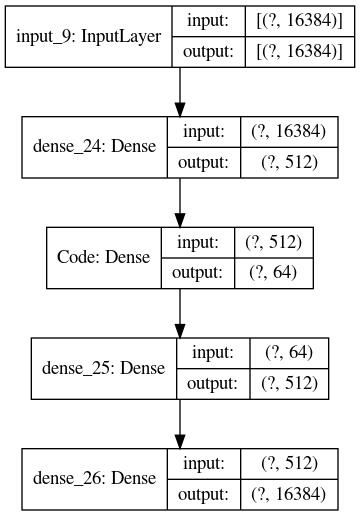

In [70]:
plot_model(model       = base_models[0], 
           show_shapes = True)

Agora, no código abaixo é realizado o processo de treinamento de cada um dos modelos. Assim como citado, esta operação será feita com o auxílio da função `exp2_test1_generate_base_model_with_different_encoding_nneurons`.

In [72]:
exp2_test2_model_with_two_layers = exp2_test1_generate_base_model_with_different_encoding_nneurons(
    n_units     = n_units, 
    x_train     = x_train, 
    x_test      = x_test,
    epochs      = 70, 
    batch_size  = 32,
    base_models = base_models
)

Para entender o comportamento de cada modelo gerado, abaixo é feita a apresentação da variação da perda de cada um deles durante o processo de treinamento.

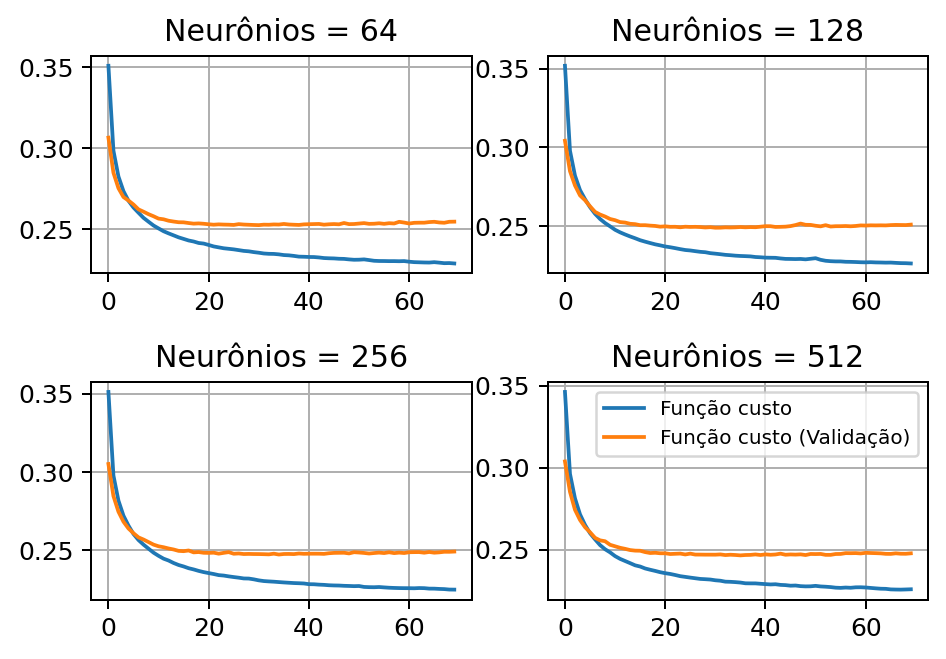

In [73]:
plot_multiple_loss_variation(exp2_test2_model_with_two_layers)

Com a adição de uma nova camada, além daquelas de codificação/decodificação com `512 neurônios`, é possível perceber avaliando a função de custo que, para todos os casos nos dados de validação, os modelos ficaram estabilizados em uma faixa de valores próximo à `0.25`. Para entender como tal comportamento impacta nos resultados gerados, abaixo é apresentada a visualização dos dados originais junto a suas reconstruções feitas por cada um dos modelos.

In [74]:
exp2_test2_model_with_two_layers = predict_using_multiple_models(exp2_test2_model_with_two_layers, x_test)

**1° Visualização das reconstruções**

In [75]:
original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test2_model_with_two_layers,
    predict_index = 50,
    x_test        = x_test
)

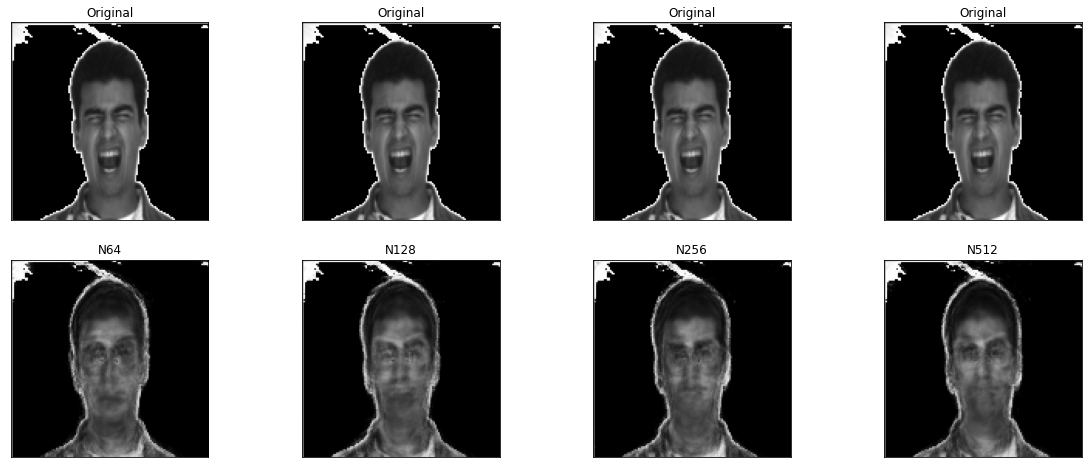

In [76]:
plt.figure(figsize=(20, 8))

# definindo legendas 
legends = ["Original", "Original", "Original", "Original",
          "N64", "N128", "N256", "N512"]

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

**2° Visualização das reconstruções**

In [77]:
original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test2_model_with_two_layers,
    predict_index = 177,
    x_test        = x_test
)

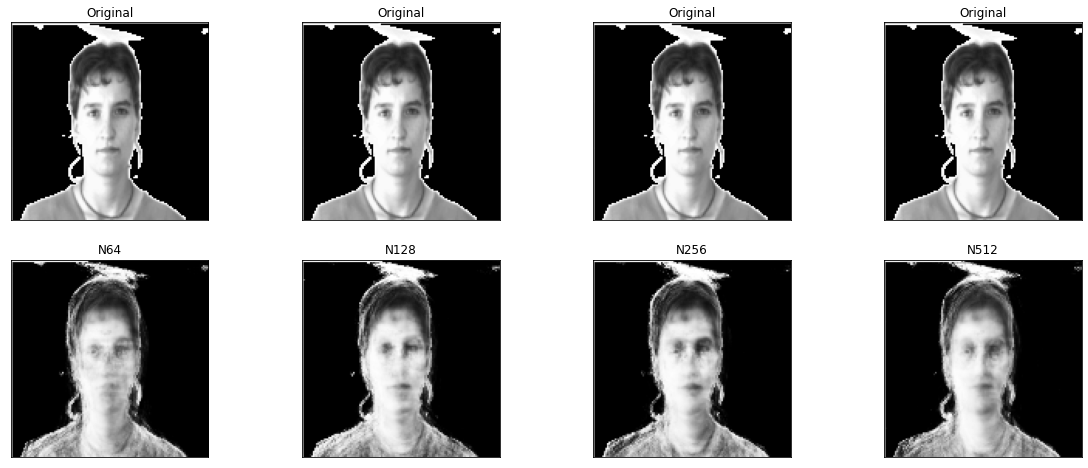

In [78]:
plt.figure(figsize=(20, 8))

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

Ao analisar os resultados acima e comparar eles com o que foi obtido na simulação `Modelos com mais neurônios`, realizada no `Experimento 2: Teste 1 - Quantidade de neurônios`, que até então haviam obtidos os melhores resultados, é possível perceber que para esse modelo com mais camadas, e consequentemente mais neurônios, tem-se a adição de mais características nas imagens que estão sendo reconstruídas. 

> A quantidade de `epochs` aplicada para esse teste pode estar influênciando o resultado. No documento, a execução é feita com `70 epochs`, porém, testes com quantidades maiores como `100` e `120` `epochs` foram feitos e os resultados não apresentaram melhoras significativas.

Seguindo a ideia de que a adição de mais camadas pode ajudar na extração de comportamentos mais complexos, sendo isso necessário para a melhor identificação das curvas e detalhes das faces presentes no conjunto de dados, a simulação seguinte é realizada com mais camadas.


**Simulação 2 - Três camadas para Encoding-Decoding**

Para finalizar este teste, seguindo os mesmos passos apresentados na simulação com `Duas camadas para Encoding-Decoding`, aqui será feita adição de uma terceira camada para o **Encoding-Decoding**. O modelo é definido abaixo e em seguinda é feita a apresentação de sua estrutura.

> Da mesma forma como feito na simulação anterior, será variada a quantidade de neurônios para a camada de codificação, utilizando as quantidades de `64`, `128`, `256` e `512` neurônios.


In [79]:
n_units = [64, 128, 256, 512]

base_models = [
    keras.Sequential([
        keras.Input(shape = (x_train.shape[1])),
        keras.layers.Dense(768,  activation = 'relu'),
        keras.layers.Dense(512,  activation = 'relu'),
        keras.layers.Dense(unit, activation = 'relu', name = "Code"),
        keras.layers.Dense(512,  activation = 'relu'),
        keras.layers.Dense(768,  activation = 'relu'),
        keras.layers.Dense(x_train.shape[1], activation = 'sigmoid')
    ]) for unit in n_units
]

Dos quatro modelos gerados seguindo a variação da quantidade de neurônios para a camada de codificação, abaixo é feita a apresentação da estrutura do primeiro deles. Os três outros modelos tem a mesma estrutura, variando apenas na quantidade de neurônios presentes na camada de codificação (Camada nomeada `Code` na figura).


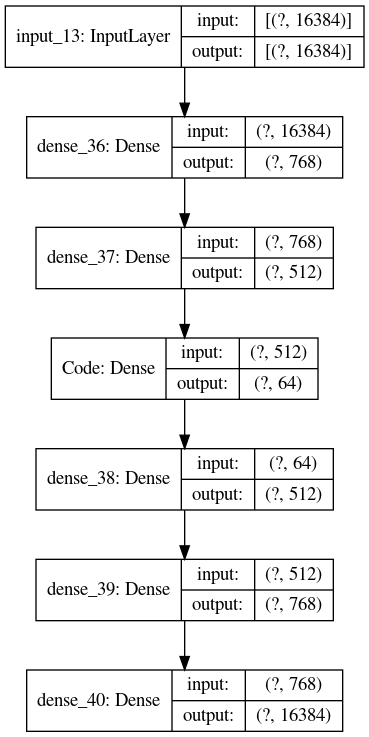

In [80]:
plot_model(model       = base_models[0],
           show_shapes = True)

Feita a definição dos modelos, abaixo é realizado o treinamento de cada um deles.

In [81]:
exp2_test2_model_with_three_layers = exp2_test1_generate_base_model_with_different_encoding_nneurons(
    n_units     = n_units,
    x_train     = x_train,
    x_test      = x_test,
    epochs      = 70,
    batch_size  = 32,
    base_models = base_models
)

Para entender o comportamento do treinamento, abaixo é feita a apresentação da função de custo para cada modelo treinado.


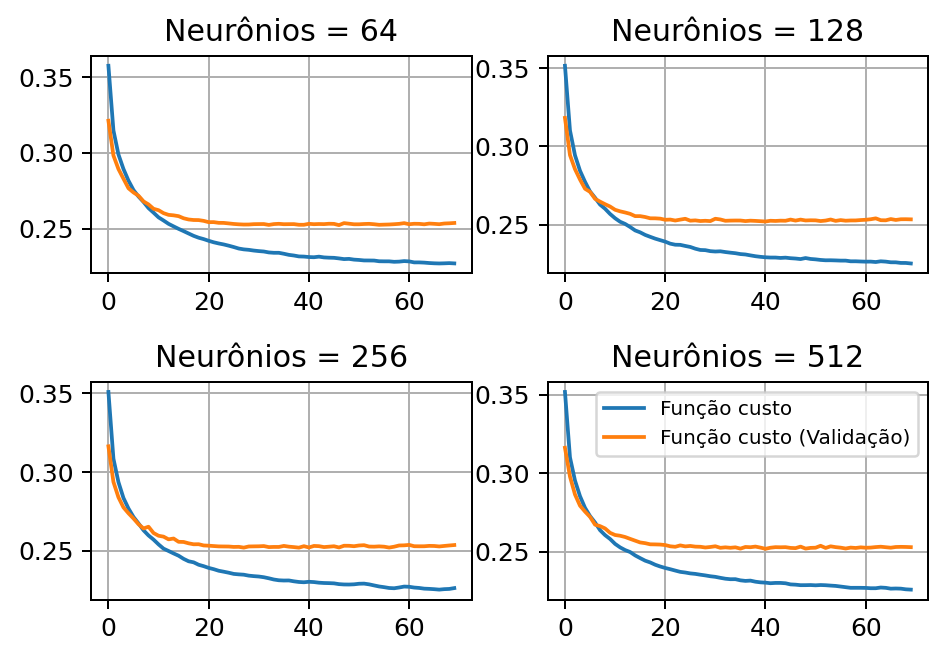

In [82]:
plot_multiple_loss_variation(exp2_test2_model_with_three_layers)

Ao analisar a figura acima é possível notar comportamento similar ao apresentado na simulação anterior, onde para os dados de treinamento a função de custo tem uma redução maior em relação aos dados de validação. Além disso, os valores da função de custo para os dados de validação também se mantiveram próximo ao valor `0.25`.

Como feito anteriormente, para entender como este comportamento impacta nos resultados gerados, é feita a visualização das reconstruções geradas por cada modelo treinado.

In [83]:
exp2_test2_model_with_three_layers = predict_using_multiple_models(exp2_test2_model_with_three_layers, x_test)

**1° Visualização das reconstruções**

In [84]:
original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test2_model_with_three_layers,
    predict_index = 50,
    x_test        = x_test
)

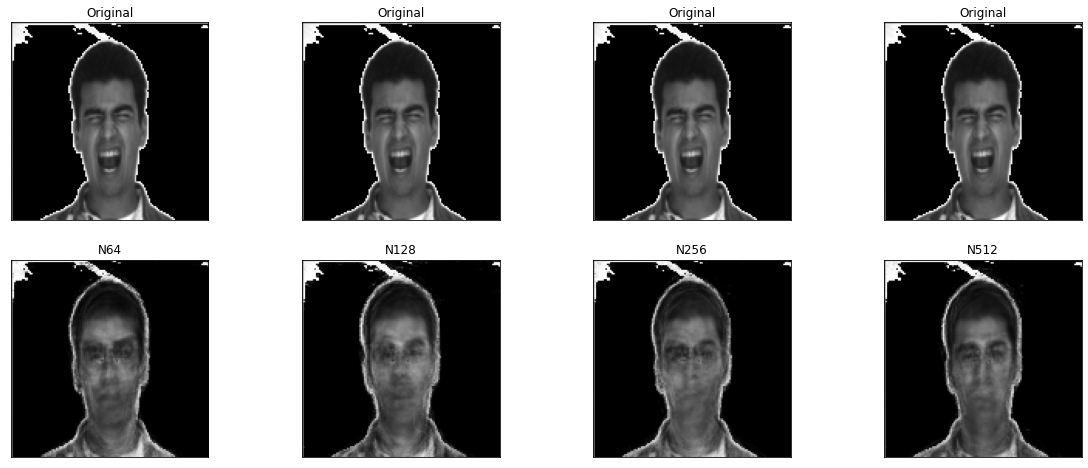

In [85]:
plt.figure(figsize=(20, 8))

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

**2° Visualização das reconstruções**

In [86]:
original_data, reconstructed_data_per_model = prepare_data_to_plot_with_one_predict_for_multiple_models(
    models_dict   = exp2_test2_model_with_three_layers,
    predict_index = 177,
    x_test        = x_test
)

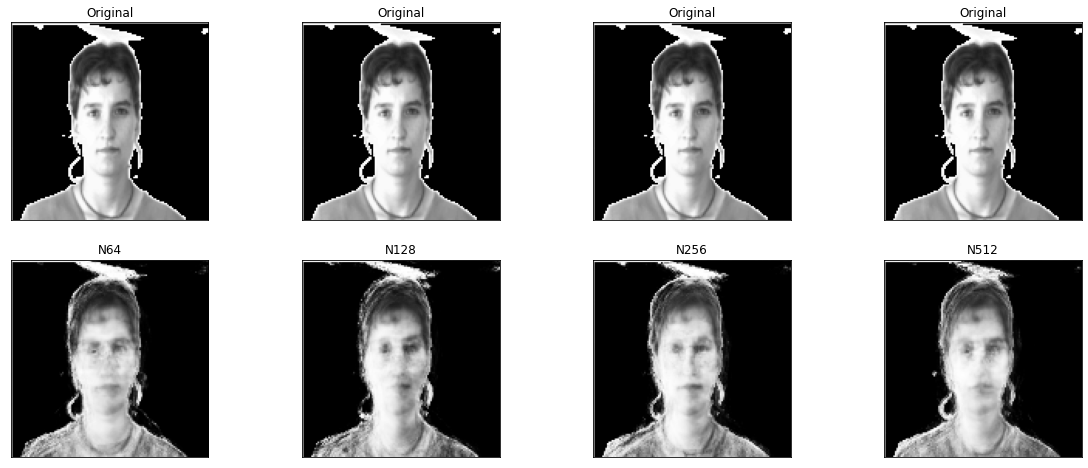

In [87]:
plt.figure(figsize=(20, 8))

visualize_reconstructed_data(
    4, original_data, reconstructed_data_per_model, (128, 128), legends
)

Para esta simulação, há características interessantes nos resultados gerados. A começar com as reconstruções feitas com a camada de codificação contendo `512 neurônios`, nessa é possível notar que a rede precisa de mais dados e mais tempo para o treinamento, já que mesmo com uma boa quantidade de unidades, há detalhes faltantes que na simulação anterior ficaram mais evidentes. Uma explicação para este comportamento é justamente a quantidade de neurônios, como neste último modelo há muitos neurônios, pode ser que a quantidade de dados presentes no conjunto de dados não seja suficiente para a rede ajustar os neurônios de modo a gerar características mais relevantes.

Por outro lado, cabe o destaque para o resultado gerado com `256 neurônios`, onde é possível ver de maneira bem mais nítida o resultado, tendo características mais parecidas com os dados de entrada.

> Vale notar que, a remoção do fundo, feita com um limiar, acabou introduzindo uma forma de ruido nas imagens, o que também pode ter influência nos resultados.
